In [86]:
from typing import TypedDict, Annotated
from operator import add
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

In [87]:
model = ChatGoogleGenerativeAI(model= "models/gemini-2.0-flash")

#### Schema

In [88]:
class EvalSchema(BaseModel):
    feedback: str = Field(description= "Detailed feedabck for essay")
    score: int = Field(description= "score out of 10",le= 10, ge= 0)

structured_model = model.with_structured_output(EvalSchema)

In [ ]:
class UPSCState(TypedDict):
    essay: str
    cot_feedback: str
    doa_feedback: str
    lang_feedback: str
    final_feedback: str
    avg_score : float
    inidividual_score : Annotated[list[int], add]
    

#### nodes(python functions)

In [90]:
def cot_func(state: UPSCState):
    essay = state['essay']
    # print(essay)
    output = structured_model.invoke(f"Analyze the claritity of thought in the essay and provide feedback and assign a score out of 10 \n {essay}")
    return {"cot_feedback": output.feedback, "inidividual_score": [output.score]}

def doa_func(state: UPSCState):
    essay = state['essay']
    output = structured_model.invoke(f"Analyze the Depth of clarity in the essay and provide feedback and assign a score out of 10 \n {essay}")
    return {"doa_feedback": output.feedback, "inidividual_score": [output.score]}

def lang_func(state: UPSCState):
    essay = state['essay']
    output = structured_model.invoke(f"Analyze the Language in the essay and provide feedback and assign a score out of 10 \n {essay}")
    return {"lang_feedback": output.feedback, "inidividual_score": [output.score]}

def final_func(state: UPSCState):
    # summary
    summary = structured_model.invoke(f"Based on the following feedbacks create a summarized feedback \n language feedabck {state["lang_feedback"]} \n clarity of thought feedback {state["cot_feedback"]} \n depth of knowledge feedabck - {state["doa_feedback"]}")
    
    # avg_score
    avg_score = sum(state["inidividual_score"])/len(state["inidividual_score"])
    return {"final_feedback": summary, "avg_score": avg_score}


#### Graph

In [91]:
graph = StateGraph(UPSCState)

# nodes
graph.add_node('cot', cot_func)
graph.add_node('doa', doa_func)
graph.add_node('lang', lang_func)
graph.add_node('final', final_func)

# edges
graph.add_edge(START, 'cot')
graph.add_edge(START, 'doa')
graph.add_edge(START, 'lang')

graph.add_edge('cot', 'final')
graph.add_edge('doa', 'final')
graph.add_edge('lang', 'final')

graph.add_edge('final', END)

In [92]:
workflow = graph.compile()

#### Workflow execution.

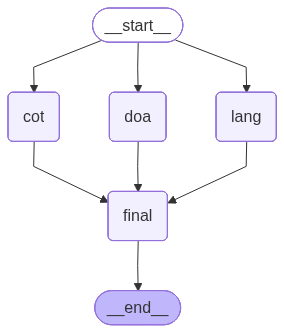

In [93]:
workflow

In [94]:
essay = """India and AI Time

Now world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.

India have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.

In farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.

But problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.

One more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.

India must all people together – govern, school, company and normal people. We teach AI and make sure AI not bad. Also talk to other country and learn from them.

If India use AI good way, we become strong, help poor and make better life. But if only rich use AI, and poor no get, then big bad thing happen.

So, in short, AI time in India have many hope and many danger. We must go right road. AI must help all people, not only some. Then India grow big and world say "good job India"."""

In [95]:
initial_state = {
    "essay": essay,
    "cot_feedback": '',
    "doa_feedback": '',
    "lang_feedback": '',
    "final_feedback": '',
    "avg_score" : 0,
    "inidividual_score" :[] 
}
final_state = workflow.invoke(initial_state)

In [96]:
from pprint import pprint

In [97]:
for k, i in final_state.items():
    pprint(f"{k} -- \n {i}")

('essay -- \n'
 ' India and AI Time\n'
 '\n'
 'Now world change very fast because new tech call Artificial Intel… something '
 '(AI). India also want become big in this AI thing. If work hard, India can '
 'go top. But if no careful, India go back.\n'
 '\n'
 'India have many good. We have smart student, many engine-ear, and good IT '
 'peoples. Big company like TCS, Infosys, Wipro already use AI. Government '
 'also do program “AI for All”. It want AI in farm, doctor place, school and '
 'transport.\n'
 '\n'
 'In farm, AI help farmer know when to put seed, when rain come, how stop bug. '
 'In health, AI help doctor see sick early. In school, AI help student learn '
 'good. Government office use AI to find bad people and work fast.\n'
 '\n'
 'But problem come also. First is many villager no have phone or internet. So '
 'AI not help them. Second, many people lose job because AI and machine do '
 'work. Poor people get more bad.\n'
 '\n'
 'One more big problem is privacy. AI need big big